## Key Results

### Regularized Biot-Savart Law Integrand
Plot of the regularized Biot-Savart law integrand for a circular loop.

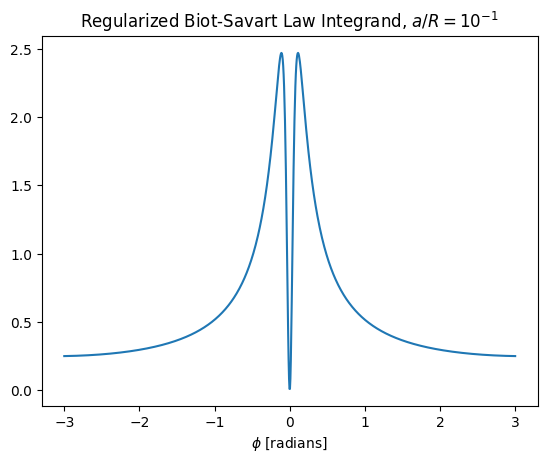

In [16]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams.update({'font.size': 10})
def f(x):
   return (1-np.cos(x))/(2*(1-np.cos(x))+0.01*np.exp(-0.5))**1.5

x = np.linspace(-3, 3, 1000)

plt.plot(x, f(x))

plt.title('Regularized Biot-Savart Law Integrand, $a/R=10^{-1}$')
plt.xlabel(r'$\phi$ [radians]')
plt.savefig("sin.pdf", bbox_inches='tight')

### Self-Force

The force data came from running `force_plots(Wire::hsx(0.326955182*0.01, 1e6, 1), 0, 200, "f_profiles", 0,1e-9, 1e-9);` in `runner.cpp`.

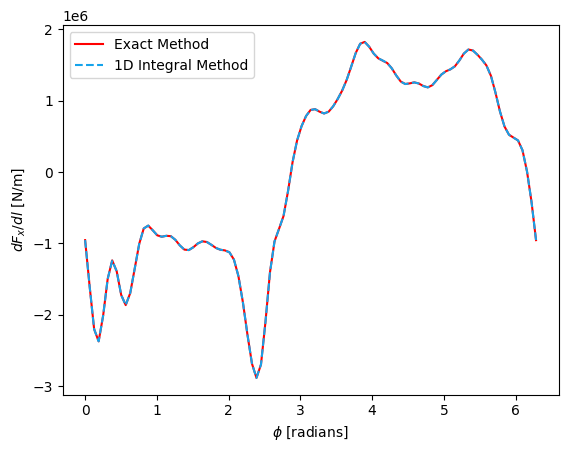

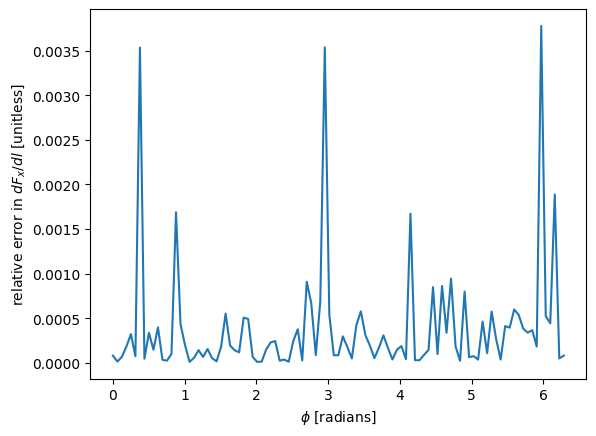

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 10})


f = open("data/f_profiles.txt", "r")

ar = np.loadtxt(f)
phi = ar[:, 0]
fhi = ar[:, 1]
flo = ar[:, 2]

phi = np.append(phi, phi[0] +2 * np.pi)
fhi = np.append(fhi, fhi[0])
flo = np.append(flo, flo[0])
rel_err = np.abs(2 * (fhi - flo) / (fhi + flo))

plt.figure()
plt.plot(phi, fhi, label="Exact Method",color="red")
plt.plot(phi, flo, '--', label="1D Integral Method",color="#15A3EB")
plt.xlabel(r'$\phi$ [radians]')
plt.ylabel(r'$dF_x/dl$ [N/m]')
plt.legend()
plt.savefig("self-force.pdf")

plt.figure()
plt.plot(phi, rel_err)
plt.xlabel(r'$\phi$ [radians]')
plt.ylabel(r'relative error in $dF_x/dl$ [unitless]')
plt.savefig("relative_self-force.pdf")

### Magnetic Field

Here, we generate contours of the magnetic field and compare between the 1D integral method "lofi" and the high-fidelity exact method "hifi". The data can be generated from the `runner.cpp` C++ file using the `contours_1D` and `contours` methods, respectively. To generate the data displayed below, the following code was executed:
```
contours_1D(Wire::hsx(0.326955182*0.1, 1e6, 1), 0, 70, "lofi"); //lofi |B| contour data
contours(Wire::hsx(0.326955182*0.1, 1e6, 1), 0, 70, "hifi"); //hifi |B| contour data
```



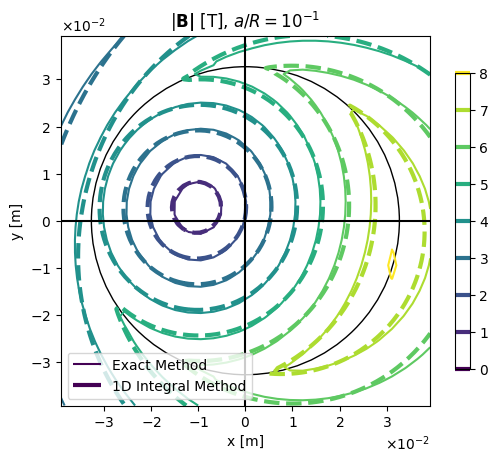

In [3]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def contour(exactname,lofiname, radius, phi):
    matplotlib.rcParams.update({'font.size': 10})
    k=0
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    f = open("data/"+ exactname + ".txt", "r")

    ar = np.loadtxt(f)
    x = ar[:, 0]
    y = ar[:, 1]
    b = ar[:, 2]

    # convert 1d array to meshgrid
    X, Y = np.meshgrid(np.unique(x), np.unique(y))
    B = np.empty(np.shape(X))
    for i in range(np.shape(B)[0]):
        for j in range(np.shape(B)[1]):
            wherex = np.where(x == X[i, j])
            wherey = np.where(y == Y[i, j])
            loc = np.intersect1d(wherex, wherey)[0]
            B[i, j] = b[loc]
            if (b[loc] == 0):
                B[i, j] = math.nan
                print(B[i, j])

    CS1 = ax.contour(X, Y, B, 8,levels=[0,1,2,3,4,5,6,7,8]) #,linestyles='dashed'

    f = open("data/"+ lofiname + ".txt", "r")

    ar = np.loadtxt(f)
    x = ar[:, 0]
    y = ar[:, 1]
    b = ar[:, 2]

    # convert 1d array to meshgrid
    X, Y = np.meshgrid(np.unique(x), np.unique(y))
    B = np.empty(np.shape(X))
    for i in range(np.shape(B)[0]):
        for j in range(np.shape(B)[1]):
            wherex = np.where(x == X[i, j])
            wherey = np.where(y == Y[i, j])
            loc = np.intersect1d(wherex, wherey)[0]
            B[i, j] = b[loc]
            if (b[loc] == 0):
                B[i, j] = math.nan
                print(B[i, j])

    CS2 = ax.contour(X, Y, B, 8, linestyles='dashed', linewidths=3, levels=[0,1,2,3,4,5,6,7,8]) #,linestyles='dashed'

    # plot axes and circle representing wire boundary
    circle1 = plt.Circle((0, 0), radius, color='black', fill=False)
    ax.add_patch(circle1)
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    ax.set_title(r'$|\bf{B}|$ [T], $a/R=10^{-1}$')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')

    plt.ticklabel_format(axis='both', style='sci', scilimits=(0, 0), useMathText=True)
    h1, _ = CS1.legend_elements()
    h2, _ = CS2.legend_elements()
    ax.legend([h1[0], h2[0]], ['Exact Method', '1D Integral Method'],loc='lower left')
    CB = fig.colorbar(CS2, shrink=0.8)
    # plt.show()
    plt.savefig("1_10.pdf")

contour("B_hifi_1e-1","B_lofi_1e-1", 0.326955182*0.1,0)



### Self-Inductance

Here, we evaluate the accuracy of the self-inductance as calculated in the 2D integral model using data obtained by executing the following code in `runner.cpp`:
```
L_plots(100, "L_hifi", 1e-9,1e-9, 1e-4, Wire::hsx(0.00326955182, 1e6, 1).a_self_intersect()*0.99/0.326955182);
L_2D_plots(100,"L_lofi",1e-12,1e-12,1e-4, Wire::hsx(0.00326955182, 1e6, 1).a_self_intersect()*0.99/0.326955182);
```

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 10})

# data loading
l_hifi = open("data/L_hifi.txt", "r")
l_lofi = open("data/L_lofi.txt", "r")

ar_hi = np.loadtxt(l_hifi)
ar_lo = np.loadtxt(l_lofi)

asp_rat = ar_hi[:, 0]
l_hifi =ar_hi[:, 1]
l_lofi = ar_lo[:, 1]
rel_err = np.abs(2 * (l_hifi - l_lofi) / (l_hifi + l_lofi))

# plot L vs aspect ratio
plt.figure()
plt.plot(asp_rat, l_hifi, color="red",label="Exact Method")
plt.plot(asp_rat, l_lofi, '--', color="#15A3EB",label="2D Integral Method")
plt.xlabel('Inverse aspect ratio (a/R) [unitless]')
plt.ylabel('Inductance [H]')
plt.xscale("log")
plt.legend()
plt.show()


# plot relative error between L hi-fi and L lo-fi
plt.figure()
plt.plot(asp_rat, rel_err)
plt.xlabel('Inverse aspect ratio (a/R) [unitless]')
plt.ylabel('Relative error between methods [unitless]')
plt.xscale("log")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data/L_hifi.txt'

We also evalaute the numerical convergence of the self-inductance solutions with respect to number of grid points. This data was obtained by running `L_2D_convergence_plots("L_conv",100,Wire::hsx(0.00326955182, 1e6, 1));` in `runner.cpp`.


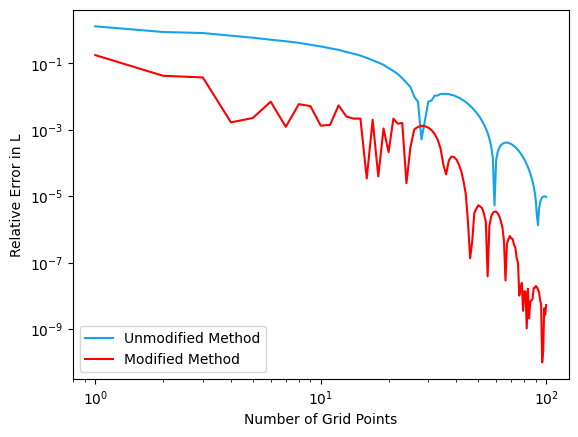

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

f = open("data/L_conv.txt", "r")
matplotlib.rcParams.update({'font.size': 10})

ar = np.loadtxt(f)
grid = ar[:, 0]
mod = ar[:, 1]
unmod = ar[:, 2]

plt.plot(grid, unmod, label="Unmodified Method",color="#15A3EB")
plt.plot(grid, mod, label="Modified Method",color="red")
plt.xlabel('Number of Grid Points')
plt.ylabel('Relative Error in L')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig("L_conv.pdf")

## Comparing Modified and Unmodified Regularized Biot-Savart Laws

The following data was obtained by executing the following command in `runner.cpp`:
```
biot_conv(0.326955182/100,600,"modified",{5,12},{12,40})
```

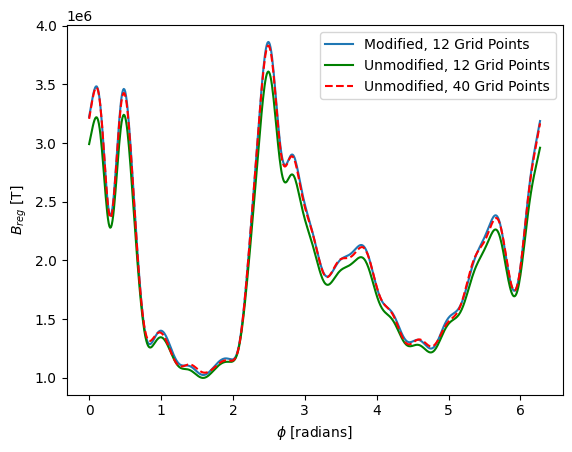

In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 10})

f = open("data/modified.txt", "r")
ar = np.loadtxt(f)
phi = ar[:, 0]

plt.plot(phi, ar[:,2]*10**6, label="Modified, 12 Grid Points")
plt.plot(phi, ar[:,3]*10**6, label="Unmodified, 12 Grid Points",color="g")
plt.plot(phi, ar[:,4]*10**6, '--',label="Unmodified, 40 Grid Points",color="r")

plt.xlabel(r'$\phi$ [radians]')
plt.ylabel(r'$B_{reg}$ [T]')
plt.legend()
plt.savefig("mod_vs_unmod.pdf")

## Plots of $\max_{s,\theta}|\textbf{B}|$

This compares the maximum magnetic field along a coil between three methods: a full, high fidelity method; numerically maximizing an analytic expression; and a fully analytic approximation. The data was obtained from `maxB_plots(Wire::hsx(0.00326955182, 1e6, 1),200, "maxB", 1e-3);` from `runner.cpp`. 

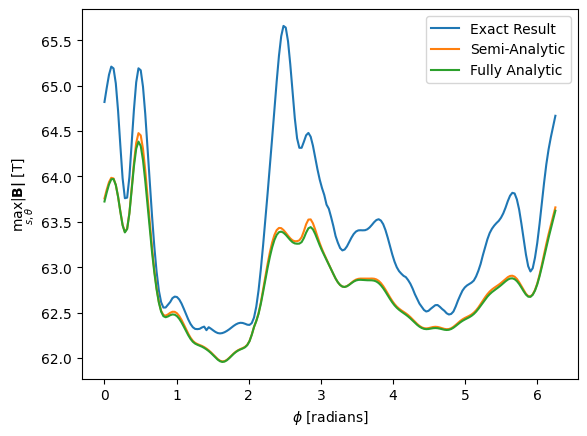

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 10})

f = open("data/maxb.txt", "r")
ar = np.loadtxt(f)
phi = ar[:, 0]
hifi = ar[:, 1]
semi = ar[:, 2]
fully = ar[:,3]

plt.plot(phi, hifi, label="Exact Result")
plt.plot(phi, semi, label="Semi-Analytic")
plt.plot(phi, fully, label="Fully Analytic")

plt.xlabel(r'$\phi$ [radians]')
plt.ylabel(r'$\max_{s,\theta}|\bf B |$ [T]')
plt.legend()
plt.savefig("maxb.pdf")

## Timing Comparisons Between C++ and Ansys

The goal of this section is to perform a timing comparison between ANSYS and our custom one-dimensional integral method in order to hopefully demonstrate our method's success. 

### CAD Model
First, we load the coil that we wish to work with and convert into a `.step` file so that it can be loaded into the finite element analysis (FEA) software Ansys.

In [6]:
from simsopt.configs.zoo import get_hsx_data
import cadquery as cq
import numpy as np

a = 0.01*0.326955182 #minor radius, giving aspect ratio of 100
pts = get_hsx_data(Nt_coils=16, Nt_ma=10, ppp=200)[0][0].gamma()

def CAD_coil(points, a):
    #convert from meters to mm for CAD
    points *= 1000
    a *= 1000
    
    # Scale system to order(1)
    scale = 1.0 / a
    len = points.shape[0]
    points = points * scale
    points = np.concatenate((points, points)) 
    points = [tuple(points[i]) for i in range(points.shape[0])]

    # Create two cleanly-cut solid halves of the coil
    path_1 = cq.Workplane().spline(points[0:len-1]).val() 
    path_2 = cq.Workplane().spline(points[int(0.5*len):int(1.5*len)-1]).val()
    tp_1 = cq.Plane(origin=path_1.positionAt(0), normal=path_1.tangentAt(0))
    tp_2 = cq.Plane(origin=path_2.positionAt(0), normal=path_2.tangentAt(0))
    sp = cq.Plane(origin=path_1.positionAt(0.25), normal=path_1.tangentAt(0.25))
    seg_1 = cq.Workplane(tp_1).circle(1).sweep(path_1)
    seg_1 = cq.Workplane(sp).add(seg_1).center(0,0).split(keepTop=True)
    seg_2 = cq.Workplane(tp_2).circle(1).sweep(path_2)
    seg_2 = cq.Workplane(sp).add(seg_2).center(0,0).split(keepBottom=True)
    
    # Fuse the coil together and add a cross-section
    scaled_res = cq.Workplane().add(seg_1.union(seg_2))
    cross_section = cq.Workplane(tp_1).circle(1).extrude(0.001).faces("<Z")
    scaled_res.add(cross_section)

    # Scale system back to original size
    result = cq.Workplane()
    for o in scaled_res.objects:
        result = result.add(o.scale(1.0/scale))
    
    return result

result = CAD_coil(pts, a)
cq.exporters.export(result, "data/Ansys calculations/hsx.step")
display(result)

### Parsing `.fld` Files

Next, we obtain magnetic field data in the form of the Ansys-standard `.fld` file, which describes the field as $[x, y, z, B_x, B_y, B_z]$. We can define a helpful function that determines the RMS error between two different `.fld` files, assuming that they share the same grid of points:

In [7]:
def RMS_field_error(filename0, filename1):
    def load_fld(filename):
        f = open(filename, "r")
        ar = np.loadtxt(f, skiprows=1)
        f.close()
        x = ar[:,0]
        y = ar[:,1]
        z = ar[:,2]
        bx = ar[:,3]
        by = ar[:,4]
        bz = ar[:,5]
        b = np.sqrt(bx**2 + by**2 + bz**2)
        return(np.transpose(np.array([x, y, z, b])))

    b0 = load_fld(filename0)
    b1 = load_fld(filename1)
    b_err = 2 * (b0[:, 3] - b1[:,3]) / (b0[:,3] + b1[:,3])
    b_RMS = np.sqrt(np.mean(b_err**2))
    return b_RMS    

### Determining Field Convergence
Our first goal is to determine the convergence of the magnetic fields for Ansys/the 1D integral models with respect to number of passes/quadrature points. Here, we use the RMS error in the magnetic field as evaluated over a large grid within the coil as a test of convergence.

#### 1D Integral Model
For the 1D integral model, the converged solution is given by an adaptive solve, `b_on_grid("data/grid", Wire::hsx(0.01*0.326955182, 1e6, 1))`, while the solutions evaluated with a finite number of Gauss-Legendre grid points are given by iterating `b_on_grid(name, Wire::hsx(0.01*0.326955182, 1e6, 1), 2, n_pts)` for various `n_pts`.

 # Grid Points    Numerical RMS Error
---------------  ---------------------
       0               0.0201355
       1               0.0144617
       2               0.0157221
       3               0.0136847
       4              0.00880905
       5              0.00662135
       6              0.00491381
       7              0.00391843
       8              0.00252821
       9              0.00227783
      10               0.0015018
      11              0.00120674
      12              0.00110075
      13              0.00072867
      14              0.000689625
      15              0.000389413
      16              0.000505602
      17              0.000359875
      18              0.000271994
      19              0.00017951


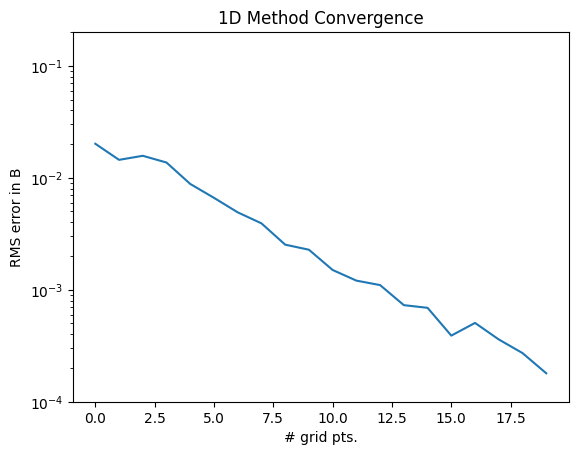

In [37]:
import os
from tabulate import tabulate
import matplotlib.pyplot as plt

filenames = np.sort([f.path for f in os.scandir("data/Ansys calculations/fld_files/cpp/convergence tests")])

# remove an extra file that appears on mac ocassionally
remove = np.char.find(filenames, '.DS')
for i in range(len(filenames)):
    if remove[i] != -1: filenames = np.delete(filenames, i)

# proceed with convergence tests
RMS_errs = [RMS_field_error(filenames[i], filenames[i+1]) for i in range(len(filenames)-1)]
grid_pts = [i for i in range(len(filenames)-1)]
header = ["# Grid Points", "Numerical RMS Error"]
data = np.transpose(np.array([grid_pts, RMS_errs]))
print(tabulate(data, headers=header, numalign="center"))

plt.figure()
plt.plot(grid_pts, RMS_errs)
plt.xlabel("# grid pts.")
plt.ylabel("RMS error in B")
plt.title("1D Method Convergence")
plt.ylim([1e-4,2e-1])
plt.yscale('log')
plt.show()

#### Ansys

Next, we evaluate convergence of the magnetic field as generated by Ansys. (For this calculation, the mesh density was initialized to "Coarse" and permitted a 50% refinement on each subsequent pass. Note that initializing the mesh to much higher densities caused failure of the mesh.) 

First, let's double-check that the Ansys results and 1D integral results are in the same ballpark. (We don't expect perfect agreement since the 1D calculation will be slightly off from the full 3D calculation). As seen below, this is indeed the case!

In [20]:
import os
import numpy as np

filenames = np.sort([f.path for f in os.scandir("data/Ansys calculations/fld_files/ANSYS/convergence tests")])

# remove an extra file that appears on mac ocassionally
remove = np.char.find(filenames, '.DS')
for i in range(len(filenames)):
    if remove[i] != -1: filenames = np.delete(filenames, i)
    
RMS_errs_ansys = RMS_field_error(filenames[-1], "data/Ansys calculations/fld_files/cpp/converged.fld")
print(f"The RMS error between the Ansys and 1D calculations is {RMS_errs_ansys}.")

The RMS error between the Ansys and 1D calculations is 0.031129055705166917.


Now, let's actually identify convergence of the Ansys calculation.

 Pass #    Numerical RMS Error
--------  ---------------------
   1              0.111
   2            0.0960472
   3            0.0526721
   4            0.0277838
   5            0.018217
   6            0.0126899
   7           0.00668669


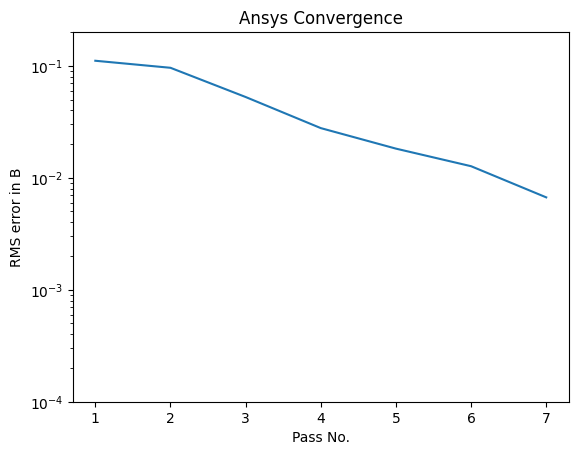

In [40]:
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

filenames = np.sort([f.path for f in os.scandir("data/Ansys calculations/fld_files/ANSYS/convergence tests")])

# remove an extra file that appears on mac ocassionally
remove = np.char.find(filenames, '.DS')
for i in range(len(filenames)):
    if remove[i] != -1: filenames = np.delete(filenames, i)

# perform analysis
RMS_errs_ansys = [RMS_field_error(filenames[i], filenames[i+1]) for i in range(len(filenames)-1)]
pass_nos = [i+1 for i in range(len(filenames)-1)]

header = ["Pass #", "Numerical RMS Error"]
data = np.transpose(np.array([pass_nos, RMS_errs_ansys]))
print(tabulate(data, headers=header, numalign="center"))

plt.figure()
plt.plot(pass_nos, RMS_errs_ansys)
plt.xlabel("Pass No.")
plt.ylabel("RMS error in B")
plt.ylim([0,0.15])
plt.title("Ansys Convergence")
plt.ylim([1e-4,2e-1])
plt.yscale('log')
plt.show()